In [12]:
from asyncio import subprocess
import sys 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
sys.path.insert(0, "../../")
import subprocess
import spycone as spy

# Transcript-level workflow

## Prepare the dataset

The dataset is SARS-Cov-2 infection with 4 time points and 3 replicates. 

In [13]:
#sample data
subprocess.call("wget https://zenodo.org/record/7228475/files/tutorial_alt_sorted_bc_tpm.csv?download=1 -O alt_sorted_bc_tpm.csv", shell=True)
subprocess.call("wget https://zenodo.org/record/7228475/files/tutorial_alt_genelist.csv?download=1 -O alt_genelist.csv", shell=True)

data = pd.read_csv("alt_sorted_bc_tpm.csv", sep="\t")
genelist = pd.read_csv("alt_genelist.csv", sep="\t")

geneid= list(map(lambda x: str(int(x)) if not np.isnan(x) else x,  genelist['gene'].tolist()))
transcriptid = genelist['isoforms'].to_list()

--2022-10-20 12:10:49--  https://zenodo.org/record/7228475/files/tutorial_alt_sorted_bc_tpm.csv?download=1
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13511185 (13M) [text/plain]
Saving to: ‘alt_sorted_bc_tpm.csv’

     0K .......... .......... .......... .......... ..........  0% 2,60M 5s
    50K .......... .......... .......... .......... ..........  0% 2,67M 5s
   100K .......... .......... .......... .......... ..........  1% 2,67M 5s
   150K .......... .......... .......... .......... ..........  1% 2,26M 5s
   200K .......... .......... .......... .......... ..........  1% 2,88M 5s
   250K .......... .......... .......... .......... ..........  2% 2,83M 5s
   300K .......... .......... .......... .......... ..........  2% 2,18M 5s
   350K .......... .......... .......... .......... ..........  3% 2,40M 5s
   400K .......... .......... ..........

Read the data to the dataset function.

In [14]:
dset = spy.dataset(ts=data,
        transcript_id=transcriptid,
        gene_id = geneid,
        species=9606,
        keytype='entrezgeneid',
        timepts=4, reps1=3)

Import biological network of your choice with `BioNetwork`, Spycone provides Biogrid, IID network in entrez ID as node name. Please specify the keytype if you are using a different ID.

In [15]:
bionet = spy.BioNetwork(path="human", data=(('weight',float),))

## Preprocessing

Filtering out genes that has expression across all time points lower than 1. By giving the biological network, it removes genes from the dataset that are not in the network.

In [16]:
spy.preprocess(dset, bionet, cutoff=1)

Input data dimension: (3, 105891, 4)
Removed 74708 objects lower than 1
Removed 2950 objects from dataset that are not in the network
Removed 11704 nodes from network that are not in the dataset (included the genes with lower than cutoff expression).
Filtered data: (3, 19479, 4)


## Detect isoform switch
iso object contains method for isoform switch detect and total isoform usage calculation.

In [17]:
iso = spy.iso_function(dset)
        #run isoform switch
ascov=iso.detect_isoform_switch(filtering=False, min_diff=0.05, corr_cutoff=0.5, event_im_cutoff=0.1, p_val_cutoff=0.05)

0 of genes with low expression are filtered out!!.
calculating for 6420 genes...
----Result statistics----
Total genes with IS genes: 762
Events found: 1146
Events with affecting domains: 555
Mean event importance: 0.5009707442637327
Mean difference before and after switch: 0.11674309600858125
--------------------------
DONE


`iso.detect_isoform_switch` returns a dataframe containing the metrics of all isoform switch events detected. \

`iso_ratio` : ratio of switching time to number of time points \
`diff` : difference of relative abundances before and after switch \
`p_value` : combined p-value of maj_pval and min_pval (corresponding p-value from t-test of the transcripts) \
`corr` : dissimilar correlation (inverted pearson correlation) \
`final_sp` : best switch point \
`event_importance` : the ratio of the relative abundance of the events to the highest expressed transcripts \
`exclusive_domains` : domain loss/gain of the event \
`adj_pval` : p-values after multiple test correction 

In [18]:
ascov.head()

,gene,gene_symb,major_transcript,minor_transcript,switch_prob,corr,diff,event_importance,exclusive_domains,p_value,adj_pval
0,1019,CDK4,ENST00000552862.1,ENST00000257904.11,1.0,0.822139,0.066160,0.343667,[],0.002980,0.002838
1,54882,ANKHD1,ENST00000433049.5,ENST00000394722.7,1.0,0.706529,0.073003,0.891058,"[PF00013, PF12796]",0.056052,0.039891
2,9140,ATG12,ENST00000379594.7,ENST00000509910.2,1.0,0.613932,0.050557,0.537392,[PF04110],0.028167,0.022642
3,64419,MTMR14,ENST00000353332.9,ENST00000431250.1,1.0,0.663200,0.062577,0.564498,[],0.001605,0.001549
4,51184,GPN3,ENST00000228827.8,ENST00000537466.6,1.0,0.913216,0.089762,0.189560,[],0.001605,0.001549


You can also plot out the genes using `switch_plot`, by provide your dataset object and the result dataframe from detect_isoform_switch. 

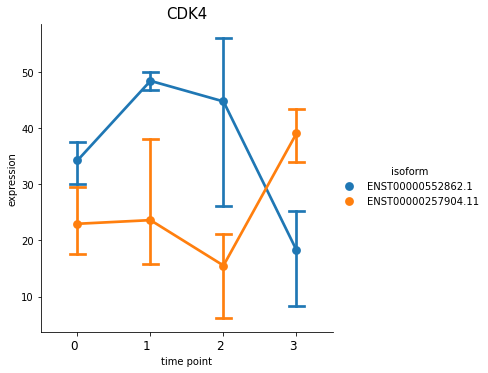

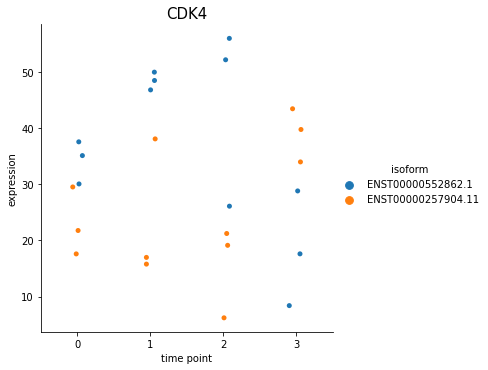

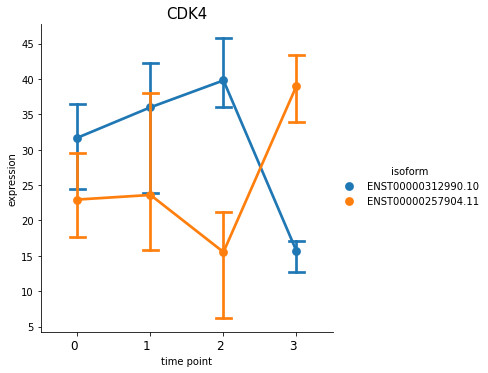

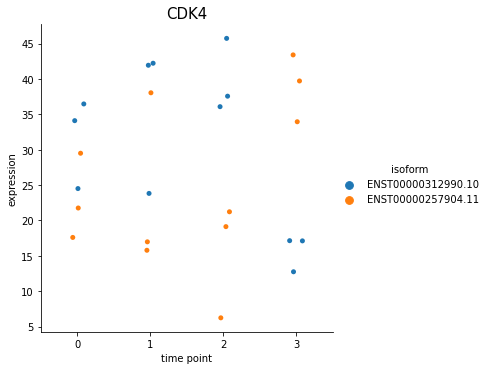

In [19]:
%matplotlib inline
spy.switch_plot("CDK4", dset, ascov)

With this function, you can also plot all isoforms in one view, by putting `all_isoforms=True`.

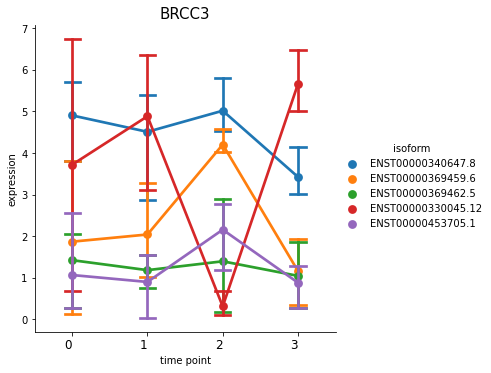

In [20]:
%matplotlib inline
spy.switch_plot("BRCC3", dset, ascov, all_isoforms=True)

## Clustering of total isoform usage

Total isoform usage measures the magnitude of change of isoform relative abundance over time. It indicates the changes due to post-transcriptional regulation (e.g. aternative splicing). You can cluster the genes with total isoform gene, thus getting groups of gene with similar patterns of change of total isoform usage over time.

In [21]:
dset = iso.total_isoform_usage(ascov, gene_level=True)

In [22]:
asclu = spy.clustering(dset, algorithm='hierarchical', metrics="euclidean", linkage="ward", input_type="isoformusage", n_clusters=8, composite=False)
c = asclu.find_clusters()

clustering took 0.09741950035095215s. 


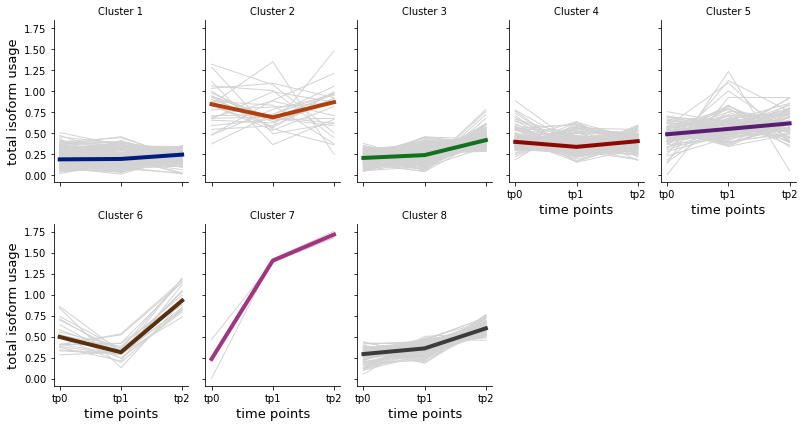

In [23]:
%matplotlib inline
spy.vis_all_clusters(asclu, col_wrap=5,y_label="total isoform usage")

## Gene set enrichment analysis

Perform gene set enrichment analysis using `clusters_gsea`. Change the gene_sets parameter into the choice of your knowledge base or gene set database, e.g. Reactome, KEGG, etc. Use `spy.list_genesets` to view the available knowledge base.

With the isoform switch detection, we can enriched the domains affect by the isoform switch events using `Nease`. 

In [24]:
asclu_go = spy.clusters_gsea(dset, 9606, is_results=ascov, method="nease", gene_sets = ['Reactome'])

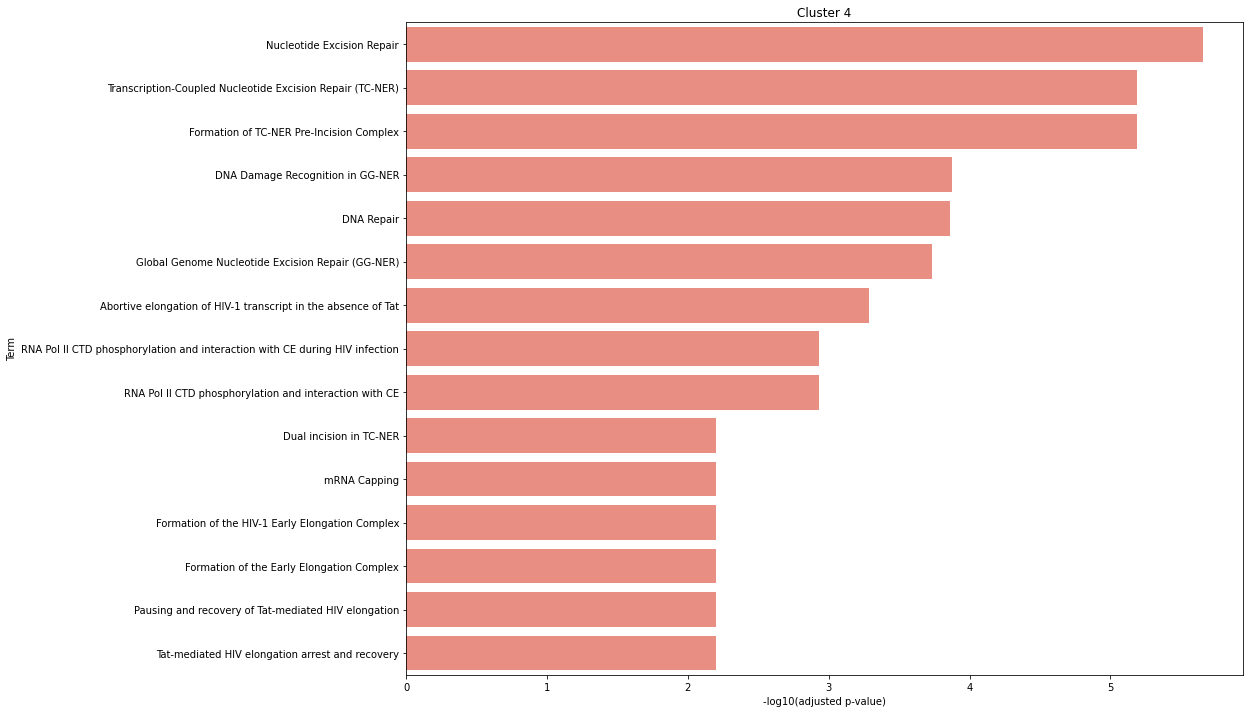

In [25]:
%matplotlib inline
spy.gsea_plot(asclu_go, cluster=4, nterms=15)

## DOMINO on the domain level

In [26]:
mods = spy.run_domino(asclu, network_file=bionet, output_file_path="./slices/newslices.txt")

FileNotFoundError: [Errno 2] No such file or directory: './slices/newslices.txt'

## Splicing Factor analysis

Perform co-expression analysis to look for splicing factors with similar expression patterns as isoform relative abundance.

In [ ]:
sf=spy.SF_coexpression(dset, padj_method="fdr_bh",corr_cutoff=0)
sf_df, cluster_sf = sf.coexpression_with_sf()

Read gtf annotation file for exons information.

In [ ]:
from gtfparse import read_gtf

dir = "/nfs/proj/spycone/"
gtf = read_gtf(os.path.join(dir,"exons.gtf"))

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'tag', 'ccds_id', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version']


Co-expression analysis result in dataframe `sf_df` that contains the co-expressed splicing factors and the corresponding cluster. We are specifically interesting in splicing factors that positively and negatively correlated to isoforms in the same gene. 

In [ ]:
thiscluster=6 #which cluster
end="5p" #specify 3'p or 5'p 
sub = sf_df[sf_df['cluster']==thiscluster].drop_duplicates() 
subcount = sub.groupby(['iso_genesymb', 'sf']) #extract list of co-expressed splicing factors
subcount = subcount['bin_corr'].agg(sum).reset_index()
subcount=subcount[subcount['bin_corr']==0]

To perform motif search, `SF_motifsearch` creates a motif object, taking a list of splicing factors, list of genes (e.g. genes in a cluster), dataset object, and the gtf file). Motif searching (`search_motifs`) will be focusing on `loss exons` or `gain exons` with `exons` parameter and `3p` or `5p` end with `site` parameter. Background are the constants exons which can be done by `search_background_motifs`.  

Motif search may take a long time, it is recommended to run in command line environment.

In [ ]:
motif=spy.SF_motifsearch(subcount['sf'].unique(), asclu.symbs_clusters[thiscluster], dataset=dset, gtf=gtf)
lossmots = motif.search_motifs(exons="loss", site=end)
gainmots = motif.search_motifs(exons="gain", site=end)
bg = motif.search_background_motifs(site=end)

In [ ]:
alldf=motif._df_forvis(lossmots, gainmots, bg=bg)
pvals = motif._get_pvals(alldf)

<Figure size 576x648 with 0 Axes>

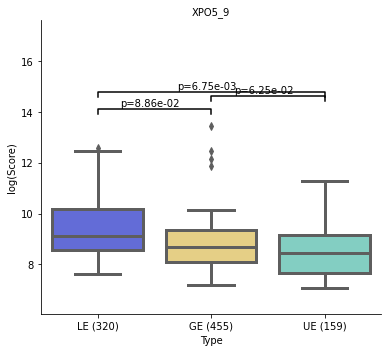

In [ ]:
palette = {"lost exons":"#505BEA",
            "gained exons": "#F5D776",
           "background":"#76DACA"}
motif.vis_motif_density(alldf=alldf, pvals=pvals, pval_cutoff=0.05, palette=palette)